In [3]:
import json
import csv
import math
import os
import imageio
import cProfile
import numpy as np
import plotly.io as pio
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from matplotlib.patches import Wedge

# Load Parameters & Data

In [76]:
path=r"Runs\Thu_Jan_11_22_00_13_2024/"

In [77]:
def save_param(path):
    csv_file_path=path+"params.csv"
    # Open the CSV file
    with open(csv_file_path, mode='r') as infile:
        reader = csv.reader(infile)
        mydict = {rows[0]:rows[1] for rows in reader}
    return mydict

def load_data(path):
    with open(path+'particle_positions.json', 'r') as file:
        data = json.load(file)
    return data

variable_dict=save_param(path)

r=float(variable_dict["sigma"])/2.0
numParticles=int(variable_dict["numParticles"])
boxSize=float(variable_dict["boxSize"])
numSteps=int(variable_dict["numSteps"])
timestep=float(variable_dict["timestep"])
dataCompression=int(variable_dict["dataCompression"])
try : theta=(float(variable_dict["theta"])) 
except : theta=(variable_dict["theta"]) 

data = load_data(path)
particle_data = np.array(data)

print(variable_dict)

{'comment': 'Trying to fix the undilutnss issue', 'epsilon': '1', 'sigma': '1', 'numParticles': '100', 'boxSize': '100.025', 'temperature': '0.00497512', 'cutoff': '1.12246', 'my_gamma': '7.05346', 'timestep': '0.0141774', 'numSteps': '1000000', 'dataCompression': '1000', 'period': '100', 'NoOfPeriods': '1000', 'theta': '15', 'R_0': '1.5', 'D_R': '0.08', 'D_T': '0.000705346', 'Pe': '200', 'v_0': '0.141069', 'Omega': '5'}


# Minimum Image Convention Negator

In [5]:
def min_image_convention(dx, box_size):
    # Apply minimum image convention to get the shortest distance
    dx -= np.round(dx / box_size) * box_size
    return dx

In [6]:
marker_shapes = {
    15: 'o',   # Circle
    20: '^',   # Triangle
    25: 's',   # Square
    30: 'D',   # Diamond
    35: 'p',   # Pentagon
    40: '*',   # Star
    45: 'v',   # Inverted triangle
    60: '<',   # Left-pointing triangle
    90: '>',   # Right-pointing triangle
    }
cmap = plt.get_cmap('tab20')  # You can choose a different colormap


# Plot Energy

In [78]:
def energy_plotly_plotter(xlabel, ylabel):
    size=len(particle_data)
    legend_names = ["Kinetic Energy", "Potential Energy", "Total Energy"]
    colors = ['blue', 'green', 'red']
    energies=[0,0,0]

    # Calculate  kinetic, potential and total energy per particle for each time step
    energies[0] = np.average(0.5 * np.sum( particle_data[:, :, 2:4] ** 2, axis=2), axis=1)
    energies[1] = particle_data[:,-1, -1]  #last particle last column contains the avergae PE per particle for that timestep
    energies[2] = energies[0] + energies[1]

    # Create Plotly figure
    fig = go.Figure()
    time = [i*dataCompression*timestep for i in range(size-1)]
    for i in range(3): fig.add_trace(go.Scatter(x=time, y=energies[i], mode='lines', name=legend_names[i], line=dict(color=colors[i])))

    fig.update_layout(title="Energy Plot", xaxis_title=xlabel, yaxis_title=ylabel, width=1200, height=600)
    pio.write_html(fig, path+'tempi.html')
    fig.show()

energy_plotly_plotter("Time", "Energy per Particle")

# Final Frame Plotter

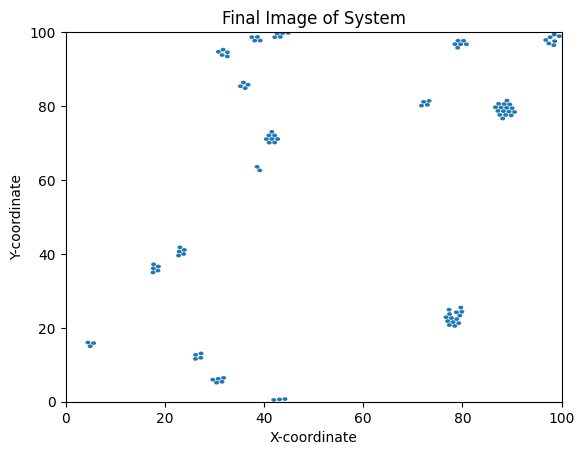

In [79]:
def FinalSysImagePlotter(box_size):
    # Create a figure and axis for the Plot
    fig, ax = plt.subplots()
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    
    for x, y, vx, vy, phi, _ in particle_data[-1]:
        circle = plt.Circle((x, y), radius=r, linewidth=0)
        # sector = Wedge((x, y), 6, np.degrees(phi - theta), np.degrees(phi + theta), ec='black')
        # plt.gca().add_patch(sector)
        # add arrow to show direction of motion
        # ax.arrow(x, y, vx, vy, width=0.001, head_width=0.01, head_length=0.01, fc='k', ec='k')
        ax.add_patch(circle)

    # Set axis labels and title
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Final Image of System')
    
    # Save the plot before showing it
    plt.savefig(path + "FinalFrame.png")

    # Show the plot
    plt.show()

# Plots the final system image
FinalSysImagePlotter(boxSize)


# Animation

In [75]:
# consider only every 10th frame
skipped_particle_data = particle_data[::]
num_frames = len(skipped_particle_data)
def update(frame, box_size):
    # Function to update each frame
    plt.figure()
    plt.xlim(0, box_size)
    plt.ylim(0, box_size)

    # Plot the particles at the given frame as circles
    for x, y, _, _, _, _ in skipped_particle_data[frame]:
        circle = plt.Circle((x, y), radius=r, linewidth=0)
        # add an if statement to change the color for the last particle in the list
        plt.gca().add_patch(circle)
    return plt

def generate_frames_parallel(frame, box_size):
    frame_plt = update(frame, box_size)
    frame_path = os.path.join(path, f'frame_{frame}.png')
    frame_plt.savefig(frame_path)
    plt.close()

# Use joblib for parallel execution
Parallel(n_jobs=-1)(delayed(generate_frames_parallel)(frame, boxSize) for frame in tqdm(range(num_frames)))

# Combine frames into a GIF using imageio
with imageio.get_writer(path+'animation.gif', duration=0.1) as writer:
    for frame in range(num_frames):
        frame_path = os.path.join(path, f'frame_{frame}.png')
        image = imageio.imread(frame_path)
        writer.append_data(image)
    

# Delete individual PNG files
for frame in range(num_frames):
    frame_path = os.path.join(path, f'frame_{frame}.png')
    os.remove(frame_path)

100%|██████████| 1000/1000 [00:18<00:00, 53.81it/s]
C:\Users\alanb\AppData\Local\Temp\ipykernel_2892\1560283854.py:30: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



In [59]:
num_frames = len(particle_data)
def update(frame, box_size):
    # ?Function to update each frame
    plt.figure()
    plt.xlim(0, box_size)
    plt.ylim(0, box_size)

    positions = particle_data[frame, :, :]
    corner_positions=positions[[0,-1, 9, -10, 73],:]
    # Plot the particles at the given frame as circles
    try:
        for x, y, vx, vy, phi, _ in particle_data[frame]:
            circle = plt.Circle((x, y), radius=r, linewidth=0)
            # add an if statement to change the color for the last particle in the list
            sector = Wedge((x, y), 6, np.degrees(phi) - theta, np.degrees(phi) + theta, ec='black')
            plt.gca().add_patch(sector)
            plt.gca().add_patch(circle)
            # plt.arrow(x, y, vx, vy, width=0.001, head_width=0.01, head_length=0.01, fc='r', ec='r')
            # plt.arrow(x, y, np.cos(phi), np.sin(phi), width=0.001, head_width=0.01, head_length=0.01, fc='r', ec='r')
        for x, y, vx, vy, phi, _ in corner_positions:
            sector = Wedge((x, y), 6, np.degrees(phi) - theta, np.degrees(phi) + theta, ec='black', fc='red')
            plt.gca().add_patch(sector)
    except:
        plt.gca().set_facecolor('black')  # Add this line to make the background black
    return plt

def generate_frames_parallel(frame, box_size):
    frame_plt = update(frame, box_size)
    frame_path = os.path.join(path, f'frame_{frame}.png')
    frame_plt.savefig(frame_path)
    plt.close()

# Use joblib for parallel execution
Parallel(n_jobs=-1)(delayed(generate_frames_parallel)(frame, boxSize) for frame in tqdm(range(num_frames)))

# ?Combine frames into a GIF using imageio
with imageio.get_writer(path+'animation.gif', duration=0.1) as writer:
    for frame in range(num_frames):
        frame_path = os.path.join(path, f'frame_{frame}.png')
        image = imageio.imread(frame_path)
        writer.append_data(image)
    

# ?Delete individual PNG files
for frame in range(num_frames):
    frame_path = os.path.join(path, f'frame_{frame}.png')
    os.remove(frame_path)

100%|██████████| 1000/1000 [00:24<00:00, 41.40it/s]
C:\Users\alanb\AppData\Local\Temp\ipykernel_2892\2288790767.py:40: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



(999, 625)
393


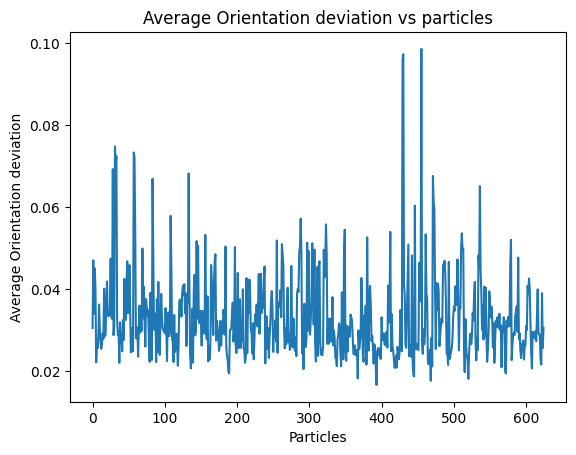

In [10]:
phi = particle_data[:1000, :, -2]
dphi = np.diff(phi, axis=0)
print (dphi.shape)
average_phi = np.average(np.abs(dphi), axis=0)
# print the position of the minimum value of average phi
print(np.argmin(average_phi))
# plot the average phi
plt.plot(average_phi)
plt.xlabel('Particles')
plt.ylabel('Average Orientation deviation')
plt.title('Average Orientation deviation vs particles')
plt.savefig(path + "AveragePhi.png")
plt.show()

# Mean Squared Displacement

In [11]:
def process_particle(i, positions, box_size, size):
    n = np.zeros((size - 1, 2))
    result = []
    for j in range(math.floor(size - 1.0)):
        d = positions[j + 1:, i] - positions[:-j - 1, i]
        d -= np.round((d - n) / (box_size)) * box_size
        n = d[:-1]
        result.append(np.mean((np.linalg.norm(d, axis=1))**2))
    return result



def MSD(Data_in, num_particles, box_size, time_step, data_compression):
    data=Data_in
    size=len(data)
    particle_data = np.array(data)
    positions = particle_data[:, :, :2]
    MSDPerParticle = np.zeros((num_particles, size - 1))

    # Create a nested for-loop running through each particle and all possible gap values to create the MSD Matrix
    MSDPerParticle=Parallel(n_jobs=-1)(delayed(process_particle)(i, positions, box_size, size) for i in tqdm(range(num_particles)))
    MSDPerParticle = np.array(MSDPerParticle)
    
    # Calculate the mean and standard deviation of the MSD values
    averageMSDPerGap=[np.mean(MSDPerParticle[:, j]) for j in range(size-1)]
    stdMSDPerGap=[np.std(MSDPerParticle[:, j]) for j in range(size-1)]

    x=[i*data_compression*time_step for i in range(math.floor(size-1.0))]
    y=averageMSDPerGap[:len(x)]
    dy=stdMSDPerGap[:len(x)]
    return x, y, dy
x,y,dy=MSD(data, numParticles, boxSize, timestep, dataCompression)


100%|██████████| 625/625 [00:01<00:00, 431.04it/s]


[ 879.02082082 2670.81342105 -893.30028652]


array([ 879.02082082, 2670.81342105, -893.30028652])

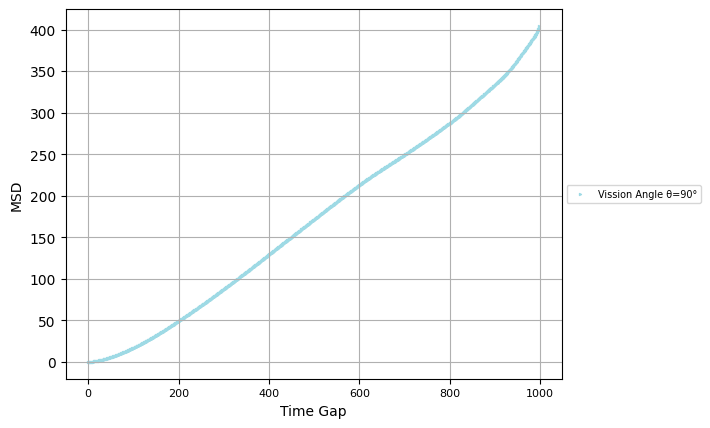

In [12]:
def plot_MSD(x,y, theta, path):
    color = cmap(theta/90)  # Use theta to get a unique color from the colormap
    theta_marker = marker_shapes.get(round(theta), 'o')  # Default to circle if theta not in the dictionary
    #fit and plot the data with an exponential function and print the fit values
    def func(v, a, b, c):
        return a * np.exp(np.array(v)/b) + c
    popt, pcov = curve_fit(func, x, y, p0=[1, 100, 0])
    # plt.plot(x, func(x, *popt), label=f'Fit:'" a="+str(round(popt[0], 2))+" b="+str(round(popt[1], 2))+" c="+str(round(popt[2], 2)), color=color)
    print (popt)
    
    # plt.plot(x, y, label=f'Vission Angle \u03B8={round(theta)}\u00B0', marker='o', color=color, markersize=1)
    plt.scatter(x, y, label=f'Vission Angle \u03B8={round(theta)}\u00B0', marker=theta_marker, color=color, s=2)
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xticks(fontsize=8)
    plt.xticks(fontsize=8)
    plt.grid(True)
    plt.xlabel("Time Gap")
    plt.ylabel("MSD")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7)
    # plt.title("Mean Squared Displacement")
    plt.savefig(path+"MSD.png")
    # return popt and theta as a dictionary
    return popt

plot_MSD(x[:],y[:], theta, path) 

# Auto-Correlation Function

In [14]:
def autoCorrelation3(datain, box_size):
    b=box_size
    data=datain
    size=len(data)
    
    particle_data = np.array(data)
    # Extracting x and y coordinates from the array
    positions = particle_data[:, :, :2]
    # Create an empty list to store the "autoCorrelation list", average autoCorrelation per gap and standard deviation of those autoCorrelation
    autoCorrelationPerParticle = np.zeros((numParticles, size - 1))

    # Create a nested for-loop running through each particle and gap values
    for i in tqdm(range(numParticles)):
        for j in range(size - 1):
            # data[k + 1][i] - data[k][i]
            d1 = min_image_convention(positions[1:-j-1, i] - positions[0:-j-2, i], b)
            d1norm = np.linalg.norm(d1, axis=1)
            # data[k + j + 2][i] - data[k + j + 1][i]
            d2 = min_image_convention(positions[j+1:-1, i] - positions[j:-2, i], b)
            d2norm = np.linalg.norm(d2, axis=1)

            dot_product = np.sum(d1 * d2, axis=1)
            autoCorrelationPerParticle[i][j] = np.sum(dot_product / (d1norm * d2norm)) / (size - j - 1)

    averageAutoCorrelationPerGap=[np.mean(autoCorrelationPerParticle[:, j]) for j in range(size-1)]
    stdAutoCorrelationPerGap=[np.std(autoCorrelationPerParticle[:, j]) for j in range(size-1)]

    x=[i*dataCompression*timestep for i in range(math.floor(size-2))]
    y=averageAutoCorrelationPerGap[:len(x)]
    dy=stdAutoCorrelationPerGap[:len(x)]
    return x, y, dy

x, y, dy=autoCorrelation3(data, boxSize)

100%|██████████| 625/625 [00:27<00:00, 22.92it/s]


[]
[3.45709539e-01 1.56031795e+03 8.00423344e+01 1.90632267e+02]


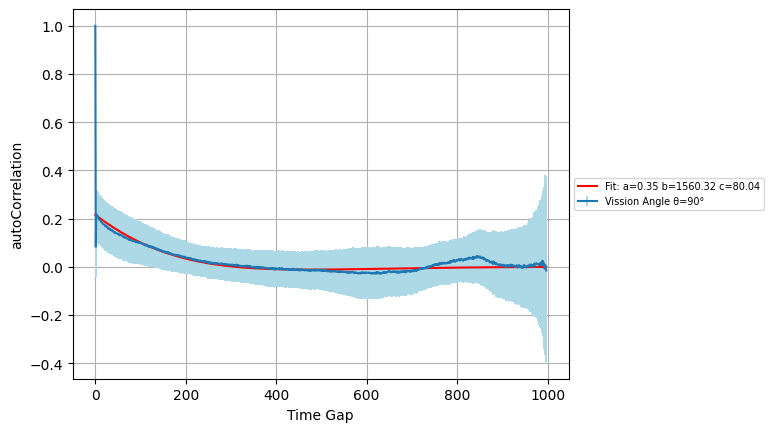

In [15]:
def plot_AutoCorrelation3(x,y, dy, theta):
    # Calculate the Fourier transform of the autoCorrelation data and Find the peaks in the Fourier transform
    fft = np.fft.fft(x)
    freq = np.fft.fftfreq(len(x), d=(dataCompression*timestep))
    peaks, properties = find_peaks(np.abs(fft), prominence=(10.0, None))
    print(2*math.pi/freq[peaks])

    # fit the curve with a sinusoidal decaying exponential
    def func(p, a, b, c, d):
        return  a*np.cos(2*math.pi * (np.array(p)+c)/b)*np.exp(- (np.array(p)+c)/d)
    popt, pcov = curve_fit(func, x, y, p0=[1.0, 100, 1.0,100])
    print(popt)
    
    # plt.plot(x, y, label=f'Vission Angle \u03B8={round(theta)}\u00B0')
    plt.errorbar(x,y, yerr=dy, ecolor = 'lightblue', capsize=0, label=f'Vission Angle \u03B8={round(theta)}\u00B0')
    plt.plot(x, func (x, *popt), label=f'Fit:'" a="+str(round(popt[0], 2))+" b="+str(round(popt[1], 2))+" c="+str(round(popt[2], 2)), color='red')
    plt.grid(True)
    plt.xlabel("Time Gap")
    plt.ylabel("autoCorrelation")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7)

    plt.savefig(path+"autoCorrelation3.png")

plot_AutoCorrelation3(x[:],y[:], dy[:], theta)


In [ ]:
def autoCorrelation():
    size=len(data)
    # Create an empty list to store the "autoCorrelation list", average autoCorrelation per gap and standard deviation of those autoCorrelation
    autoCorrelationPerParticle = [[0.0] * int(math.floor(size - 1.0)) for i in range(numParticles)]
    averageAutoCorrelationPerGap = [0.0] * math.floor(size -1.0)
    stdAutoCorrelationPerGap = [0.0] * math.floor(size -1.0)

    # Create a nested for-loop running through each particle all the possible gap values to create the autoCorrelation Matrix; here j will be called "gap"
    for i in tqdm(range(numParticles)):
        for j in range(math.floor(size -2.0)):
            for k in range(size - j - 2):
                cos1=min_image_convention((data[k+1][i][0] - data[k][i][0]), box_size) / math.sqrt(min_image_convention((data[k+1][i][0] - data[k][i][0]), box_size) ** 2 + min_image_convention((data[k+1][i][1] - data[k][i][1]), box_size) ** 2)
                cos2=min_image_convention((data[k+j+2][i][0] - data[k+j+1][i][0]), box_size) / math.sqrt(min_image_convention((data[k+j+2][i][0] - data[k+j+1][i][0]), box_size) ** 2 + min_image_convention((data[k+j+2][i][1] - data[k+j+1][i][1]), box_size) ** 2)
                autoCorrelationPerParticle[i][j] += cos1 * cos2 
            autoCorrelationPerParticle[i][j] /= (size - j - 2)

    # Create a for loop running throughall possible gap values
    for j in tqdm(range(math.floor(size-1.0))):
        autoCorrelationValues = []
        for i in range(numParticles):
            # Add the autoCorrelation of each particle at a given gap to the list
            autoCorrelationValues.append(autoCorrelationPerParticle[i][j])

        # Calculate the mean and standard deviation of the autoCorrelation values
        averageAutoCorrelationPerGap[j] = np.mean(autoCorrelationValues)
        stdAutoCorrelationPerGap[j] = np.std(autoCorrelationValues)

    # Calculate the Fourier transform of the autoCorrelation data and Find the peaks in the Fourier transform
    fft = np.fft.fft(averageAutoCorrelationPerGap)
    freq = np.fft.fftfreq(len(averageAutoCorrelationPerGap), d=(dataCompression*timestep))
    peaks, properties = find_peaks(np.abs(fft), prominence=(0.2, None))

    #  Create a new frequency spectrum with zeros everywhere and set the values at the major peak indices to the original complex amplitudes
    new_fft = np.zeros_like(fft)
    new_fft[peaks] = fft[peaks]
    # Perform Inverse Fourier Transform of the new frequency spectrum to get the reconstructed signal
    reconstructed_signal = np.fft.ifft(new_fft)

    # Fit the averageautoCorrelationPerGap data using the peak frequencies in the autoCorrelation plot
    plt.plot([i*dataCompression*timestep for i in range(math.floor(size-1.0))], averageAutoCorrelationPerGap, label='Data')
    # plt.errorbar([i*dataCompression*timestep for i in range(math.floor(size-1.0))], averageAutoCorrelationPerGap, yerr=stdAutoCorrelationPerGap, ecolor = 'lightblue', capsize=0, label='Data')
    plt.plot([i*dataCompression*timestep for i in range(math.floor(size-1.0))], reconstructed_signal, label='Fit')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid()
    plt.xlabel("Time Gap")
    plt.ylabel("autoCorrelation")
    plt.legend()
    if type(theta) == float: plt.title("VC=" + str(round(theta))+" Deg")
    else: plt.title("VC=" + str(theta))
    plt.savefig(path+"autoCorrelation.png")
    
    #Plot the Fourier transform
    fig, ax = plt.subplots()
    ax.plot(freq, np.abs(fft))
    ax.plot(freq[peaks], np.abs(fft)[peaks], "x")
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    ax.set_title('Fourier Transform of autoCorrelation Plot with Peaks')
    plt.savefig(path+"autoCorrelation_fft.png")
    

autoCorrelation()

# Persistence

In [16]:
def process_particle(i, positions, box_size, size):
    #for each particle i calculate min_image_convention(positions[1:size, i] - positions[0:size-1, i], b)
    direction_vector=min_image_convention(positions[1:, i] - positions[0:-1, i], box_size)
    dvnorm = np.linalg.norm(direction_vector, axis=1)
    direction_vector = direction_vector/dvnorm[:, np.newaxis]
    cosine_matrix = np.dot(direction_vector, direction_vector.T)
    result = []
    # Create a nested for-loop running through each particle and gap values
    for j in range(size):
        result.append(0)
        for k in range(size - j - 2):
            cosines = cosine_matrix[k,k:k+j+1]                 #Broadcasting of numpy arrays is the reason we can do the next step
            flag = np.any(cosines < 0)
            if not flag: result[j] += 1.0
        result[j] = result[j]/ int(size - j)
    return result

def persistence(datain, box_size, numParticles, data_compression, time_step):
    data=datain
    size=len(data)
    # Extracting x and y coordinates from the array
    particle_data = np.array(data)
    positions = particle_data[:, :, :2]
    persistencePerParticle = np.zeros((numParticles, size))
    persistencePerParticle=Parallel(n_jobs=-1)(delayed(process_particle)(i, positions, box_size, size) for i in tqdm(range(numParticles)))
    persistencePerParticle = np.array(persistencePerParticle)
    # Create a for loop running through persistencePerParticle[i] and finding the mean persistence
    averagePersistencePerGap=[np.mean(persistencePerParticle[:, j]) for j in range(size)]

    x = [i*data_compression*time_step for i in range(size-1)]
    y = averagePersistencePerGap[:len(x)]
    
    return x, y
x, y=persistence(data, boxSize, numParticles, dataCompression, timestep)



100%|██████████| 625/625 [01:55<00:00,  5.41it/s]


[9.07363538e-01 2.76160337e+00 2.01409228e-03]


array([9.07363538e-01, 2.76160337e+00, 2.01409228e-03])

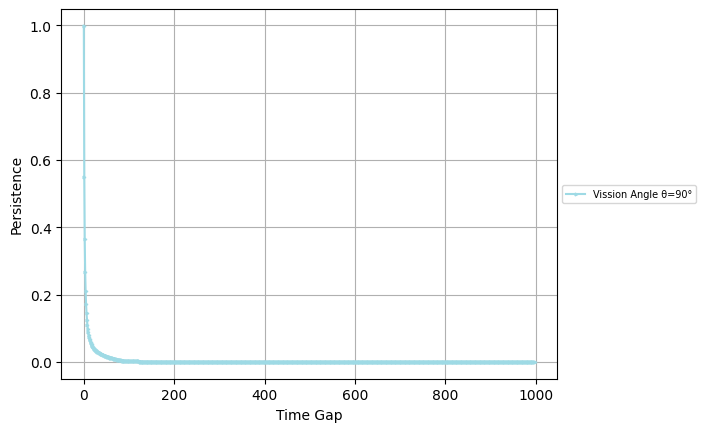

In [17]:
def plot_persistence(x, y, theta, save_path):
    color = cmap(theta/90)  # Use theta to get a unique color from the colormap
    theta_marker = marker_shapes.get(round(theta), 'o')  # Default to circle if theta not in the dictionary
    #fit and plot the data with an exponential function and print the fit values
    def func(v, a, b, c):
        return a * np.exp(-np.array(v)/b) + c
    popt, pcov = curve_fit(func, x, y, p0=[1, 100, 0])
    # plt.plot(x, func(x, *popt), label=f'Fit:'" a="+str(round(popt[0], 2))+" b="+str(round(popt[1], 2))+" c="+str(round(popt[2], 2)), color=color)
    print (popt)

    plt.plot(x, y, label=f'Vission Angle \u03B8={round(theta)}\u00B0', marker=theta_marker, color=color, markersize=2)
    # plt.scatter(x, y, label=f'Vission Angle \u03B8={round(theta)}\u00B0', marker=theta_marker, color=color, s=2)
    
    # plt.xscale('log')
    # plt.yscale('log', base=2)
    plt.grid(True)
    plt.xlabel("Time Gap")
    plt.ylabel("Persistence")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7)

    plt.savefig(save_path+"persistence.png")
    return popt
plot_persistence(x, y, theta, path)

In [14]:
def persistence(datain):
    data=datain
    size=len(data)
    # Create an empty list to store the "Persistence list" and  average persistence per gap
    persistencePerParticle = [[0.0] * (size) for i in range(numParticles)]
    averagePersistencePerGap = [0.0] * (size)
    # Create a nested for-loop running through each particle all the possible gap values to create the Persistence Matrix; here j will be called "gap"
    for i in tqdm(range(numParticles)):
        for j in range(size):
            for k in range(size - j - 1):  # -1 because we want to avoid the last particle as there is no k+1 for it
                flag = 0
                d1x = min_image_convention(data[k + 1][i][0] - data[k][i][0], box_size)
                d1y = min_image_convention(data[k + 1][i][1] - data[k][i][1], box_size)
                d1norm = math.sqrt(d1x**2 + d1y**2)
                for l in range(j + 1):
                    d2x = min_image_convention(data[k + l + 1][i][0] - data[k + l][i][0], box_size)
                    d2y = min_image_convention(data[k + l + 1][i][1] - data[k + l][i][1], box_size)
                    d2norm = math.sqrt(d2x**2 + d2y**2)
                    if (d1x * d2x + d1y * d2y) / (d1norm * d2norm) < 0:  # if cos becomes negative
                        flag = 1
                        break
                if flag == 0:
                    persistencePerParticle[i][j] += 1.0

            persistencePerParticle[i][j] /= int(size - j)


    # Create a for loop running through persistencePerParticle[i] and finding the mean persistence
    for j in tqdm(range(size)):
        persistenceValues = []
        for i in range(numParticles):
            # Add the persistence of each particle at a given gap to the list
            persistenceValues.append(persistencePerParticle[i][j])

        # Calculate the mean  of the persistence values
        averagePersistencePerGap[j] = np.mean(persistenceValues)

    x = [i*dataCompression*timestep for i in range(size-1)]
    y = averagePersistencePerGap[:len(x)]
    
    return y, x
x, y=persistence(data)

100%|██████████| 200/200 [00:00<00:00, 19732.79it/s]


# Simultaneous Averaging Plots

In [44]:
def simPlot():
    # parent_folder = r"Runs\Low Density" 
    # parent_folder = r"Runs\Mid Density" 
    parent_folder = r"Runs\High Density\CRun" 
    file_paths = [f.path+"/" for f in os.scandir(parent_folder) if f.is_dir()]
    Plot_Data={}
    No_of_Runs_per_theta={}
    for file_path in tqdm(file_paths):
        data = load_data(file_path)
        variable_dict=save_param(file_path)
        theta=(float(variable_dict["theta"]))
        numParticles=int(variable_dict["numParticles"])
        boxSize=float(variable_dict["boxSize"])
        timestep=float(variable_dict["timestep"])
        dataCompression=int(variable_dict["dataCompression"])
        
        # abc = np.array(MSD(data, numParticles, boxSize, timestep, dataCompression))
        abc = np.array(persistence(data, boxSize, numParticles, dataCompression, timestep))
        
        # Make a copy of the array before modifying its values
        # if dataCompression == 1000: a = np.array([abc[0][:-5:5], abc[1][:-5:5], abc[2][:-5:5]])
        if dataCompression == 1000: a = np.array([abc[0][:-5:5], abc[1][:-5:5]])
        else: a = abc

        if theta not in Plot_Data:
            Plot_Data[theta] = a
            No_of_Runs_per_theta[theta] = 1
        else:
            Plot_Data[theta][1] += a[1]
            No_of_Runs_per_theta[theta] += 1

    for theta in Plot_Data:
        Plot_Data[theta][1] /= No_of_Runs_per_theta[theta]
    print (No_of_Runs_per_theta)
    return Plot_Data
l=simPlot()












































































































100%|██████████| 625/625 [01:52<00:00,  5.54it/s]










































































































100%|██████████| 625/625 [02:09<00:00,  4.82it/s]










































































































100%|██████████| 625/625 [02:09<00:00,  4.81it/s]


























































100%|██████████| 625/625 [00:04<00:00, 140.14it/s]


























































100%|██████████| 625/625 [00:04<00:00, 144.50it/s]










































































































100%|██████████| 625/625 [02:09<00:00,  4.84it/s]










































































































100%|██████████| 625/625 [02:12<00:00,  4.73it/s]




{15.0: 5, 20.0: 5, 25.0: 4, 30.0: 3, 35.0: 5, 40.0: 3, 45.0: 3, 50.0: 3, 55.0: 3, 60.0: 3, 65.0: 3, 70.0: 3, 75.0: 3, 80.0: 3, 85.0: 3, 90.0: 3}


[ 1.08131066e+00  6.44934440e+01 -3.80819080e-03]
[ 1.03739818e+00  6.85108913e+01 -3.86560943e-03]
[1.00193301e+00 7.37297124e+01 2.42688261e-03]
[7.07955736e-01 2.04442695e+02 5.46153132e-02]
[1.11521692e+00 5.09133817e+01 1.73195131e-03]
[ 8.95610638e-01  1.83952782e+02 -1.31555597e-03]
[ 1.08892839e+00  7.97311289e+01 -2.93684806e-04]
[ 1.03442150e+00  9.03823136e+01 -7.29343844e-03]
[9.63107764e-01 1.07389683e+02 7.10771546e-04]
[6.82768229e-01 1.93066077e+02 1.12937171e-01]
[  0.68735476 167.84259351   0.20775797]
[ 1.07851214e+00  6.83934074e+01 -2.57924626e-03]
[ 9.81428597e-01  8.58203268e+01 -1.98981816e-03]
[ 1.03846881e+00  7.94414977e+01 -5.90717937e-03]
[ 1.05773711e+00  1.94047246e+02 -2.38964210e-02]
[  0.89710875 135.81351368   0.15473714]


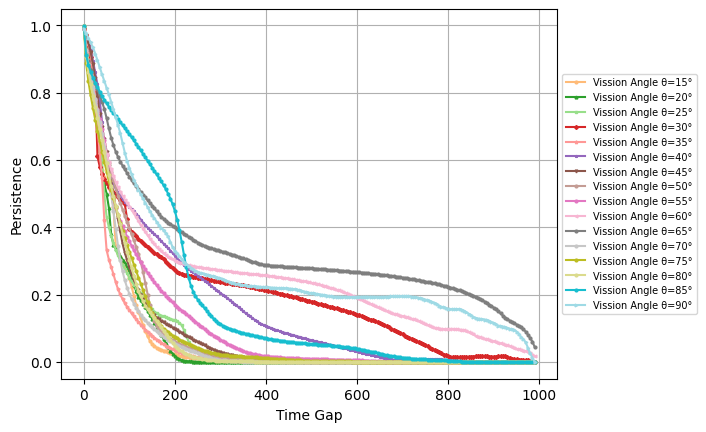

In [51]:
import pandas as pd
l = dict(sorted(l.items()))
fit_values={}
for theta in l:
        # if theta==25: continue
        popt=plot_persistence(l[theta][0], l[theta][1], theta, "Plots/")
        # popt = plot_MSD(l[theta][0], l[theta][1], theta, "Plots/")
        fit_values[theta]=popt
#output the fit values to a an excel file
import pandas as pd


# Save to Excel
df = pd.DataFrame.from_dict(fit_values, orient='index')
df.to_excel("Plots/fit_valuesPERS .xlsx")



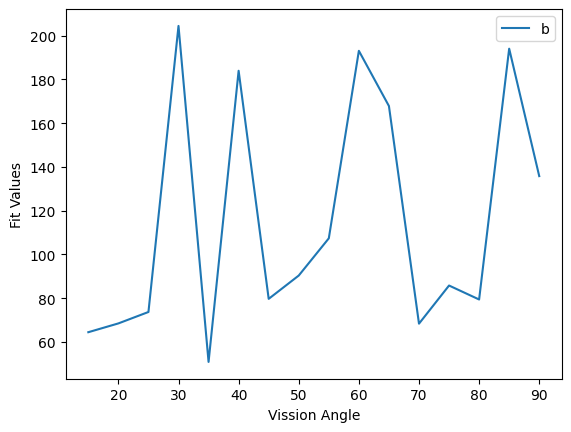

In [46]:
#plot the fit values
plt.plot(list(fit_values.keys()), [i[1] for i in list(fit_values.values())], label='b')
plt.xlabel("Vission Angle")
plt.ylabel("Fit Values")
plt.legend()
plt.savefig("Plots/fit_values.png")
plt.show()

In [ ]:
cProfile.run("persistence(data)")

In [24]:
import plotly.graph_objects as go
import numpy as np

def plot_persistence(x, y, theta, save_path):
    marker_shapes = {
        15: 'circle',
        20: 'triangle-up',
        25: 'square',
        30: 'diamond',
        35: 'pentagon',
        40: 'star',
        45: 'triangle-down',
        60: 'triangle-left',
        90: 'triangle-right',
    }
    theta_marker = marker_shapes.get(round(theta), 'circle')  # Default to circle if theta not in the dictionary

    # Fit and plot the data with an exponential function and print the fit values
    def func(v, a, b, c):
        return a * np.exp(-np.array(v) / b) + c

    popt, pcov = curve_fit(func, x, y, p0=[1, 100, 0])

    fit_trace = go.Scatter(
        x=x,
        y=func(x, *popt),
        mode='lines',
        name=f'Fit: a={round(popt[0], 2)} b={round(popt[1], 2)} c={round(popt[2], 2)}',
        line=dict(color='blue'),  # Adjust color as needed
    )

    data_trace = go.Scatter(
        x=x,
        y=y,
        mode='markers',
        name=f'Vission Angle \u03B8={round(theta)}\u00B0',
        marker=dict(symbol=theta_marker, size=6, color='red'),  # Adjust size and color as needed
    )

    layout = go.Layout(
        xaxis=dict(type='log', showgrid=True),
        yaxis=dict(type='linear', showgrid=True),  # You can change to 'log' if needed
        xaxis_title="Time Gap",
        yaxis_title="Persistence",
        legend=dict(x=1, y=0.5),
    )

    fig = go.Figure(data=[fit_trace, data_trace], layout=layout)
    fig.write_image(save_path + "persistence.png")

# Example usage:
plot_persistence(x, y, theta, path)


NameError: name 'x' is not defined